# Analysis of results from simulated data
Deeper look into a model's performance on simulated data.

In [37]:
# Imports
import numpy as np
import pprint
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from master_scripts.data_functions import (load_experiment, get_git_root, separation_distance, energy_difference,
                                           relative_energy, event_indices, normalize_image_data)
from master_scripts.analysis_functions import (mean_values_doubles, doubles_stats)
%load_ext autoreload
%autoreload 2
repo_root = get_git_root()
pp = pprint.PrettyPrinter(indent=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data and experiment import
Load the image data and split into training and validation sets. Since we specify the random seed, we can
reproduce the exact same data the model was originally validated on to explore it.

In [4]:

images = np.load(repo_root + "data/simulated/images_full.npy")
positions = np.load(repo_root + "data/simulated/positions_full.npy")
energies = np.load(repo_root + "data/simulated/energies_full.npy")
labels = np.load(repo_root + "data/simulated/labels_full.npy")

In [5]:
# Load experiment and associated model (must be a saved model instance complete with weights)
experiment_id = "4557cfeefc83"
experiment = load_experiment(experiment_id)

model = tf.keras.models.load_model(repo_root + "models/" + experiment_id + ".h5")

In [6]:
x_idx = np.arange(len(images))
train_idx, val_idx = train_test_split(
    x_idx,
    random_state=experiment['experiment_config']['random_seed']
)   

prediction = model.predict(normalize_image_data(images[val_idx]))
val_pred = (prediction > 0.5).astype(int) 

# indices, relative distances and relative energies for test set
single_indices, double_indices, close_indices = event_indices(positions[val_idx], threshold=1.0)
sep_dist = separation_distance(positions[val_idx])
energy_diff = energy_difference(energies[val_idx])
rel_energy = relative_energy(energies[val_idx], scale=False)

In [12]:
pp.pprint(experiment['metrics'])

{ 'accuracy_score': 0.9782421052631579,
  'confusion_matrix': {'FN': 9746, 'FP': 589, 'TN': 236943, 'TP': 227722},
  'f1_score': 0.9778113654759016,
  'matthews_corrcoef': 0.9571957148197215,
  'roc_auc_score': 0.9924280110669701}


## Some numbers from results
Mean separation distances, mean relative energies, events with separation < 1px etc.

In [38]:
means = mean_values_doubles(val_idx, positions, energies, val_pred)
display(means)

,Separation distance [px],Relative energy,Energy difference
All doubles,7.655674,6.618531,0.333372
Correct,7.826402,2.337818,0.325875
Wrong,3.666494,106.640349,0.508544
Correct close,0.683524,1.251185,0.287635
Wrong close,0.654193,6.510580,0.368013


In [68]:
dstats = doubles_stats(val_idx, positions, energies)
display(dstats)

,Separation distance,Relative energy,Energy difference
0,-100.000000,-100.000000,-100.000000
1,-100.000000,-100.000000,-100.000000
2,-100.000000,-100.000000,-100.000000
3,5.925332,1.516491,0.261388
4,6.001003,2.139785,0.479741
...,...,...,...
474995,-100.000000,-100.000000,-100.000000
474996,7.295113,1.391216,0.062703
474997,9.400738,0.953453,0.029681
474998,-100.000000,-100.000000,-100.000000


In [52]:
dstats.describe()

,Separation distance,Relative energy,Energy difference
count,237468.000000,237468.000000,237468.000000
mean,7.655674,6.618531,0.333372
std,3.644928,499.575402,0.235293
min,0.020616,0.000007,0.000003
25%,4.822534,0.500785,0.135056
50%,7.515719,0.999941,0.293269
75%,10.350978,1.993680,0.499611
max,19.712970,228094.700248,0.996426


In [29]:
# Separate correct and wrong classifications
correct_doubles = np.where(val_pred[double_indices] == 1)[0]
wrong_doubles = np.where(val_pred[double_indices] == 0)[0]
correct_close_doubles = np.where(val_pred[close_indices] == 1)[0]

# Mean distances
mean_dist_all = np.mean(sep_dist[double_indices])
mean_dist_correct = np.mean(sep_dist[double_indices][correct_doubles])
mean_dist_wrong = np.mean(sep_dist[double_indices][wrong_doubles])

# Mean energies
mean_energy_all = np.mean(rel_energy[double_indices])
mean_energy_correct = np.mean(rel_energy[double_indices][correct_doubles])
mean_energy_wrong = np.mean(rel_energy[double_indices][wrong_doubles])

# Mean energy difference
mean_energydiff_all = np.mean(energy_diff[double_indices])
mean_energydiff_correct = np.mean(energy_diff[double_indices][correct_doubles])
mean_energydiff_wrong = np.mean(energy_diff[double_indices][wrong_doubles])


# Ratios
ratio_doubles = len(correct_doubles) / len(double_indices)
ratio_close = len(correct_close_doubles) / len(close_indices)


# Output
print("Number of events:")
print("Single: {} \nDouble: {} \nClose: {}\n".format(
    len(single_indices),
    len(double_indices),
    len(close_indices))
     )
print("Mean separations for classified double events:")
print("All doubles: {:.2f}mm \nCorrect: {:.2f}mm \nWrong: {:.2f}mm\n".format(
    mean_dist_all,
    mean_dist_correct,
    mean_dist_wrong)
     )

print("Mean relative energy for classified double events:")
print("All doubles: {:.2f} \nCorrect: {:.2f} \nWrong: {:.2f}\n".format(
    mean_energy_all,
    mean_energy_correct,
    mean_energy_wrong)
     )
print("Mean energy difference for classified double events:")
print("All doubles: {:.2f} \nCorrect: {:.2f} \nWrong: {:.2f}\n".format(
    mean_energydiff_all,
    mean_energydiff_correct,
    mean_energydiff_wrong)
     )
print("Ratios of correctly classified double events:")
print("All doubles: {:.3f} \nClose: {:.3f}\n".format(
    ratio_doubles,
    ratio_close)
     )

print("Ratio of correct singles: %.3f" % (19749/len(single_indices)))

Number of events:
Single: 237532 
Double: 237468 
Close: 3274

Mean separations for classified double events:
All doubles: 7.66mm 
Correct: 7.83mm 
Wrong: 3.67mm

Mean relative energy for classified double events:
All doubles: 6.62 
Correct: 2.34 
Wrong: 106.64

Mean energy difference for classified double events:
All doubles: 0.33 
Correct: 0.33 
Wrong: 0.51

Ratios of correctly classified double events:
All doubles: 0.959 
Close: 0.356

Ratio of correct singles: 0.083


## Confusion Matrix
The confusion matrix can be a useful metric to gain a little bit
more insight into specifically what the model gets wrong.
* Top left: Single events classified as single events
* Top right: Single events classified as double events
* Bottom left: Double events classified as single events
* Bottom right: Double events classified as double events

#### Close events

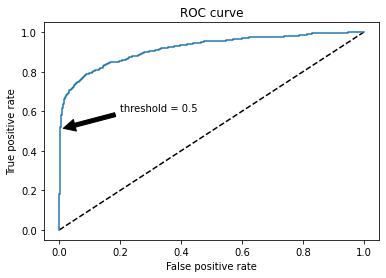

Area under curve: 0.9189985985556286
F1-score close:  0.6404405979543667


In [11]:
single_close_true = np.concatenate((y_true[single_indices], y_true[close_indices]), axis=0)
single_close_pred = np.concatenate((tmp_predicted[single_indices,1], tmp_predicted[close_indices,1]), axis=0)
plot_roc_curve(single_close_true, single_close_pred)
plt.show()
print("Area under curve:",roc_auc_score(single_close_true, single_close_pred))
single_close_pred = np.concatenate((y_pred[single_indices], y_pred[close_indices]), axis=0)
score_close = f1_score(single_close_true, single_close_pred)
print("F1-score close: ", score_close)


# Distributions and scatterplot

## Test set

### Comparing correct and misclassified double events

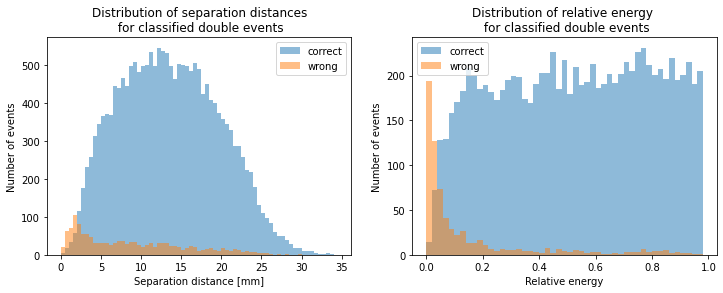

In [12]:
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, np.amax(energy_diff_test), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_test[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance_test[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Distribution of separation distances\n for classified double events")
ax[0].set_xlabel("Separation distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()
ax[1].hist(rel_energy_test[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
ax[1].hist(rel_energy_test[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].set_title("Distribution of relative energy \n for classified double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()
fig.savefig(FIGURE_PATH+net+"_relative_test_compare.pdf", format="pdf")

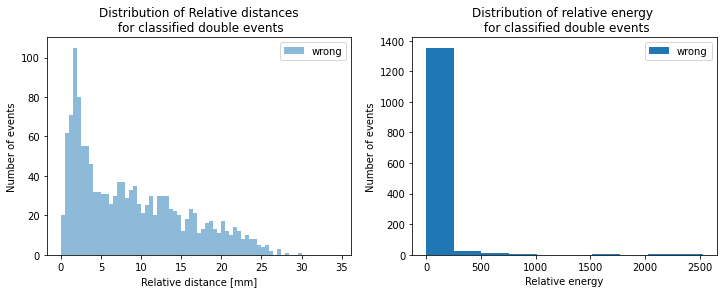

In [30]:
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, 10, 0.1)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
#ax[0].hist(rel_distance_test[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance_test[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Distribution of Relative distances\n for classified double events")
ax[0].set_xlabel("Relative distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()
#ax[1].hist(rel_energy_test[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
#ax[1].hist(rel_energy_test[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].hist(rel_energy_test[double_indices][wrong_doubles], label="wrong")
ax[1].set_title("Distribution of relative energy \n for classified double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()
fig.savefig(FIGURE_PATH+net+"_relative_test_compare.pdf", format="pdf")

### Scatterplot relative distance vs. relative energy

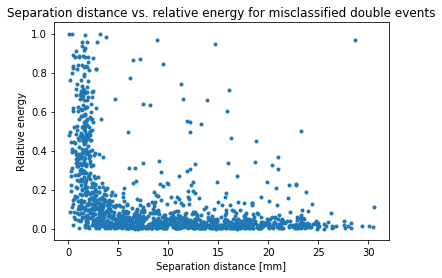

In [36]:
plt.scatter(
    rel_distance_test[double_indices][wrong_doubles], 
    rel_energy_test[double_indices][wrong_doubles],
    marker='.',
    )
plt.title("Separation distance vs. relative energy for misclassified double events")
plt.xlabel("Separation distance [mm]")
plt.ylabel("Relative energy")
plt.show()

## Events with high separation distance
and varying relative energy above a threshold

In [37]:
# Grab the indices
separation_lim = 20.0
energy_lim = 0.2
high_relD = np.where(rel_distance_test[double_indices][wrong_doubles] > separation_lim)[0]
high_relE = np.where(rel_energy_test[double_indices][wrong_doubles] > energy_lim)[0]

# Then get the overlapping indices
high_both = np.array(list(set(high_relD).intersection(set(high_relE))))
print("Found {} events.".format(len(high_both)))



Found 9 events.


/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


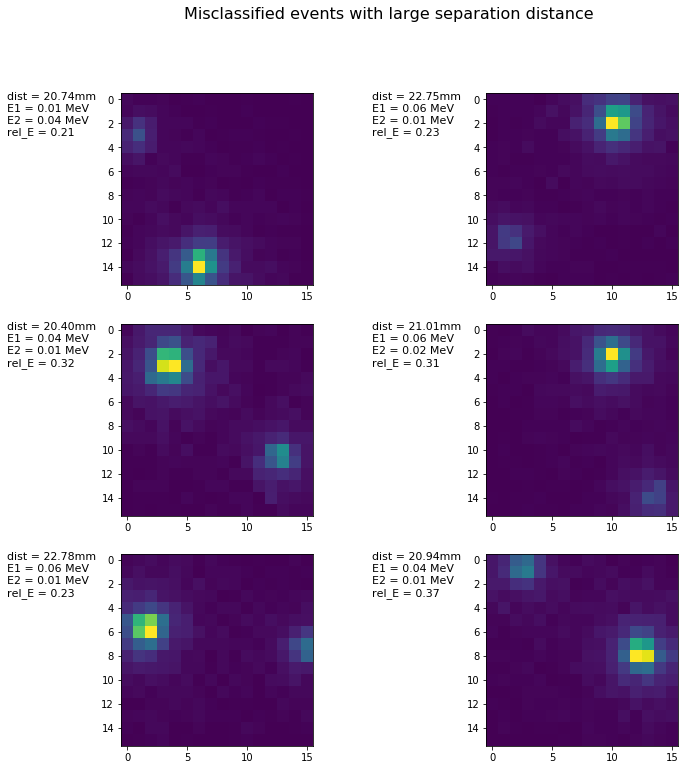

In [38]:
# Use the indices to fetch the images and other statistics we want.
images_plot_high = images[test_idx][double_indices][wrong_doubles][high_both][:,:,:,0]
rel_pos_plot_high = rel_distance_test[double_indices][wrong_doubles][high_both]
rel_energy_plot_high = rel_energy_test[double_indices][wrong_doubles][high_both]
energy_plot_high = energies[test_idx][double_indices][wrong_doubles][high_both]

# Plot the events images with relative separation, energies, and relative energy
# to the top left of each image
fig, ax = plt.subplots(3, 2, figsize=(12,12))
for i in range(3):
    for j in range(2):
        if i*2+j >= len(high_both):
            fig.delaxes(ax.flatten()[i*2 + j])
            continue
        ax[i, j].imshow(images_plot_high[i*2 + j])
        rel_pos = rel_pos_plot_high[i*2 + j]
        rel_E = rel_energy_plot_high[i*2 + j]
        E1 = energy_plot_high[i*2 + j, 0]
        E2 = energy_plot_high[i*2 + j, 1]
        relp = "dist = {:.2f}mm".format(rel_pos[0])
        rele = "rel_E = {:.2f}".format(rel_E[0])
        e1_txt = "E1 = {:.2f} MeV".format(E1)
        e2_txt = "E2 = {:.2f} MeV".format(E2)
        ax[i, j].text(-10, 0, relp, fontsize=11)
        ax[i, j].text(-10, 1, e1_txt, fontsize=11)
        ax[i, j].text(-10, 2, e2_txt, fontsize=11)
        ax[i, j].text(-10, 3, rele, fontsize=11)
        
fig.suptitle("Misclassified events with large separation distance", fontsize=16)
#fig.savefig(FIGURE_PATH+net+"_misclassified_large_dist.pdf", format="pdf")
fig.show()

# Plots of events that no networks were able to classify correctly

In [237]:
# Load indices
OUTPUT_PATH = MODEL_PATH = "../../data/output/"
fname_indices = "never_correct_indices_rerun.txt"
never_correct = np.loadtxt(OUTPUT_PATH + fname_indices, dtype=int).tolist()

rel_distance_all = relative_distance(positions)
rel_energy_all = relative_energy(energies)



## Distributions for relative distance and relative energy

W1002 18:41:38.050824 139808083375936 legend.py:1282] No handles with labels found to put in legend.
W1002 18:41:38.082546 139808083375936 legend.py:1282] No handles with labels found to put in legend.
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


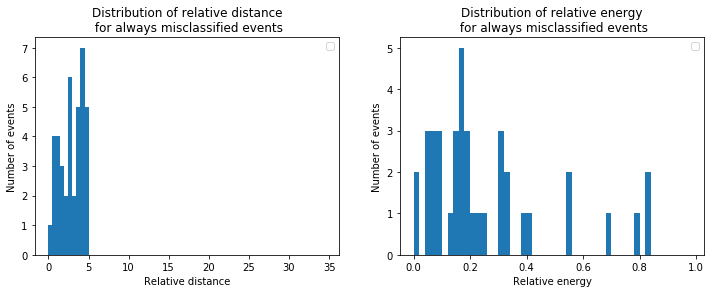

In [238]:
# Calculate bins
dist_bins = np.arange(0, np.amax(rel_distance_all), 0.5)
energy_bins = np.arange(0, np.amax(rel_energy_all), 0.02)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_all[never_correct], bins=dist_bins)
ax[0].set_title("Distribution of relative distance\n for always misclassified events")
ax[0].set_xlabel("Relative distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()

ax[1].hist(rel_energy_all[never_correct], bins=energy_bins)
ax[1].set_title("Distribution of relative energy\n for always misclassified events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()

#fig.savefig(FIGURE_PATH+net+"_relative_noncorrect.pdf", format="pdf")
fig.show()

## Plot images of some of the events

Number of always misclassified events: 39


/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


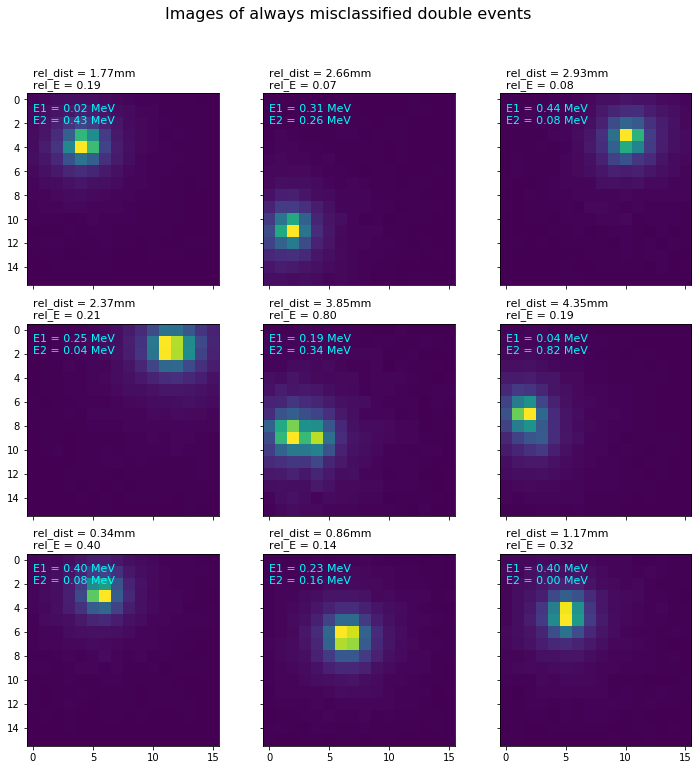

In [254]:
print("Number of always misclassified events:", len(never_correct))

images_plot = images[never_correct][:,:,:,0]
rel_dist_plot = rel_distance_all[never_correct]
rel_energy_plot = rel_energy_all[never_correct]
energy_plot = energies[never_correct]
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
index = 10
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(images_plot[index + i*3 + j])
        rel_dist = rel_dist_plot[index + i*3 + j]
        rel_energy = rel_energy_plot[index + i*3 + j]
        E1 = energy_plot[i*3 + j, 0]
        E2 = energy_plot[i*3 + j, 1]
        rel_d = "rel_dist = {:.2f}mm".format(rel_dist[0])
        rel_e = "rel_E = {:.2f}".format(rel_energy[0])

        e1_txt = "E1 = {:.2f} MeV".format(E1)
        e2_txt = "E2 = {:.2f} MeV".format(E2)
        ax[i, j].text(0,-2, rel_d, color='black', fontsize=11)
        ax[i, j].text(0,-1, rel_e, color='black', fontsize=11)
        ax[i, j].text(0,1, e1_txt, color='cyan', fontsize=11)
        ax[i, j].text(0,2, e2_txt, color='cyan', fontsize=11)


fig.suptitle("Images of always misclassified double events", fontsize=16)
#fig.savefig(FIGURE_PATH+net+"_nocorrect_samples.pdf", format="pdf")

fig.show()
        

        

In [ ]:
# Plot some images, with electron origin positions
%matplotlib inline

images = images.reshape(images.shape[0],16,16)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
for i in range(3):
    for j in range(3):
        # plot image
        ax[i, j].imshow(images[index + i*3 + j])
        
        # plot origin of event
        x = positions[index + i*3 + j, 0]
        y = positions[index + i*3 + j, 1]
        ax[i, j].plot(x, y, 'rx')
        ax[i, j].set_title('single')
        if positions[index + i*3 + j, 3] != -100:
            x2 = positions[index + i*3 + j, 2]
            y2 = positions[index + i*3 + j, 3]
            ax[i, j].plot(x2, y2, 'rx')
            ax[i, j].set_title('double')
        
plt.show()

# Distribution of position around highest intensity pixel
In previous work data analysis showed that most event positions are within the highest intensity pixel,
and all (verify!) events are within the two highest intensity pixels,
It might be reasonable to look at how the predicted positions are distributed around the highest intensity
pixel.

(14, 12)


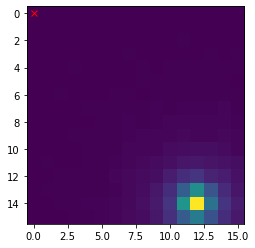

In [48]:
imgs = images[single_indices].reshape(images[single_indices].shape[0],16,16)

# get index of highest energy pixel
print(np.unravel_index(np.argmax(imgs[0], axis=None), imgs[0].shape))
fix, ax = plt.subplots()
ax.imshow(imgs[0])
ax.plot(0,0, 'rx')

In [50]:
config = {
    "DATA_PATH": "../../data/real/anodedata.txt",              
    "MODEL_PATH": "../../data/output/models/",                
    "CLASSIFIER": "Project-0.97.hdf5",                      
    "SINGLE_ENERGY_MODEL": "single_energy_model_name.hdf5",    
    "SINGLE_POSITION_MODEL": "single_position_model_name.hdf5",
    "DOUBLE_ENERGY_MODEL": "double_energy_model_name.hdf5",    
    "DOUBLE_POSITION_MODEL": "double_position_model_name.hdf5" 
}

data = import_real_data(config)
print(data['image'].type)


KeyError: 'image'